<h3>Part 3 ‑ Predictive modeling</h3>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

<h3>Summary of Predictive Models</h3>

We performed several machine learning algorithms and found that  that gradient boosting  performs best in terms of prediction accuracy (81%), roc-auc score (75%), and f1-score (87%). For this specific use case, the ultimate company will care more on the accuracy of prediction given the user is active. More specifically, Ultimate Company cares about more about how we performed in predicting out the true negative rate so that they can target these users.

Ultimate Company can use these results to predict out users who are most likely to stop using the services and see how they can improve the experience (examples being lower surge fares during surge times or discounted ultimate black services) to improve retention. These examples were taken from our exploratory analysis phase where we found that users were more likely to be retained if they were to be an ultimate black user.

<h3>Answer</h3>
<p>We see immediately that this is a classification problem as Ultimate is interested in retention from a cohort of users. Thus we would be looking at whether a user was retained or not. Our definition of retention is described per the above " we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days." Thus our first step is to create our flag for whether a user was retained or not.</p>

<p>Before we start however, we will need to import libraries that we need and first see how clean our data is.</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the database
import json

with open('ultimate_data_challenge.json', 'r') as f:
    ultimate = json.load(f)    

ultimate_df = pd.DataFrame(ultimate)

In [2]:
# Information lost at avg_rating and phone type, we will decide later if we need to fill na values by exploring relations between
# these factors with status of activity
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


<p>We can see that there are some missing data in the "avg_rating_by_driver", "avg_rating_of_driver" and the "phone" column. We can hypothesize that the phone column should have relatively low significance as it is arbitrarily assigned. Our next step is to create our classification variable so we can explore our data and see how the classification varies depending on the variables. </p>

In the below cell, we are looking for the latest date of the last trip and we will take the difference of that to the last 30 days. Any user that is within this period will be labelled as an active user.

In [3]:
from datetime import  datetime, timedelta
latestDate = datetime.strptime(ultimate_df['last_trip_date'].max(), "%Y-%m-%d")
precedingDate = latestDate - timedelta(days=30)
print(precedingDate)

2014-06-01 00:00:00


In [4]:
# create status column and drop trips_in_first_30_days

ultimate_df['status'] = ultimate_df.last_trip_date.apply(lambda x: 1 if datetime.strptime(x, "%Y-%m-%d") >= precedingDate  else 0)

ultimate_df.drop('trips_in_first_30_days', inplace = True, axis = 1)

In [5]:
print(ultimate_df['status'].value_counts())

0    31196
1    18804
Name: status, dtype: int64


In [6]:
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,ultimate_black_user,weekday_pct,status
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,False,82.4,0


<p>An interesting point of comparison is to see the average rate depending on whether they used an ultimate black car.</p>

Text(0,0.5,'Active rate')

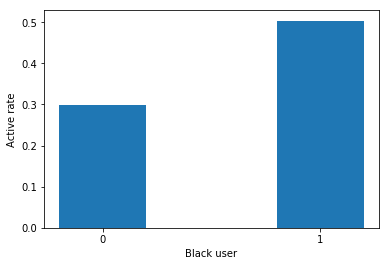

In [7]:
black_user = ultimate_df.groupby('ultimate_black_user')['status'].mean()

plt.bar(black_user.index, black_user.values, width=0.4)
plt.xticks([0,1])
plt.xlabel('Black user')
plt.ylabel('Active rate')

<p>We can see here that ultimate black users have a significantly higher tendency of staying.</p>

In [8]:
avg_dist_status = pd.concat([ultimate_df.avg_dist//10,ultimate_df.status],axis = 1).groupby('avg_dist').mean()

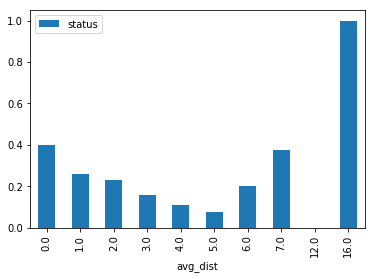

In [9]:
avg_dist_status.plot(kind='bar')

Per the above plot, we see that generally, a higher distance will result in a higher active rate.

<BarContainer object of 10 artists>

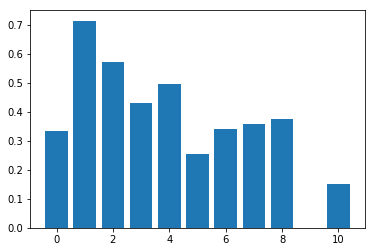

In [10]:
surge_pct_status = pd.concat([ultimate_df.surge_pct//10,ultimate_df.status],axis = 1).groupby('surge_pct').mean()

plt.bar(surge_pct_status.index, surge_pct_status['status'].values)

Lower surge pct indicates lower fare and will increase the rate of active users.

<BarContainer object of 6 artists>

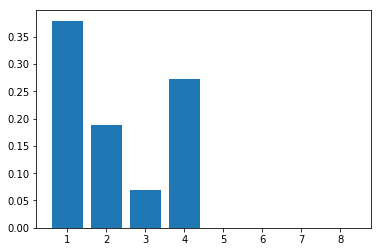

In [11]:
avg_surge_status = pd.concat([ultimate_df.avg_surge//1,ultimate_df.status],axis = 1).groupby('avg_surge').mean()

plt.bar(avg_surge_status.index, avg_surge_status['status'].values)

Higher avg surge indicates users are from high demanding area, which tends to have the higher rate of active users.

<BarContainer object of 11 artists>

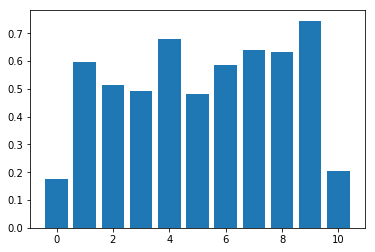

In [12]:
weekday_pct_status = pd.concat([ultimate_df.weekday_pct//10,ultimate_df.status],axis = 1).groupby('weekday_pct').mean()

plt.bar(weekday_pct_status.index, weekday_pct_status['status'].values)

Lower weekday percentage means that users do not use ultimate service often. Higher weekday percentage means the user uses ultimate service often.

<h3>Data Cleaning</h3>

In [13]:
# Drop no neccessary columns
ultimate_df.drop(['avg_rating_by_driver','avg_rating_of_driver','phone','last_trip_date','signup_date'], axis = 1, inplace=True)

In [14]:
# Convert column 'ultimate_black_user' from bool value to int values
ultimate_df.ultimate_black_user = ultimate_df.ultimate_black_user.apply(lambda x: 1 if x else 0)

# Label city terms as 1, 2, and 3
city_map = {"King's Landing":1, 'Astapor':2, 'Winterfell':3}

ultimate_df.city = ultimate_df.city.map(city_map)

# Seperate avg_dist into 10 parts
ultimate_df.avg_dist = pd.qcut(ultimate_df.avg_dist, 10, labels = range(1,11))

# Seperate avg_surge into 8 parts
ultimate_df.avg_surge = ultimate_df.avg_surge//1

# Separate surge_pct into 10 parts
ultimate_df.surge_pct = ultimate_df.surge_pct//10

# Separate weekday_pct into 10 parts
ultimate_df.weekday_pct = ultimate_df.weekday_pct//10

In [15]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
avg_dist               50000 non-null category
avg_surge              50000 non-null float64
city                   50000 non-null int64
surge_pct              50000 non-null float64
ultimate_black_user    50000 non-null int64
weekday_pct            50000 non-null float64
status                 50000 non-null int64
dtypes: category(1), float64(3), int64(3)
memory usage: 2.3 MB


In [16]:
# Convert columns to int type
for i in ultimate_df.columns:
    ultimate_df[i] = ultimate_df[i].astype(int)
    
# Make sure no null values
assert ultimate_df.isnull().sum().sum()==0

In [17]:
ultimate_df.head()

,avg_dist,avg_surge,city,surge_pct,ultimate_black_user,weekday_pct,status
0,5,1,1,1,1,4,1
1,9,1,2,0,0,5,0
2,1,1,2,0,0,10,0
3,3,1,1,2,1,8,1
4,4,1,3,1,0,8,0


<h3>Predictive Modeling</h3>
In this part, we compared the performance of random forest, knn, svc, and gradient boosting.

In [18]:
# Import model evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve

# Define model evaluation method
def model_test(model, ytest, y_predict):
    print('The accuracy of {} model is: {:.2f}'.format(model, accuracy_score(ytest, y_predict)))
    print('The confusion matrix is:\n{}'.format(confusion_matrix(ytest, y_predict)))
    print('The auc score is: {:.2f}'.format(roc_auc_score(ytest, y_predict)))
    print('The F1-score is: {:.2f}'.format(f1_score(ytest, y_predict)))

# Define auc plotting method
def plot_roc(model, ytest, y_predict, y_predict_prob):
    fpr, tpr, _ = roc_curve(ytest, y_predict_prob)
    plt.figure(figsize=(5,5))
    plt.plot(fpr,tpr, label = 'AUC score by {}: {:.2f}'.format(model, roc_auc_score(ytest, y_predict)))
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'best')
    plt.xlim(0,1)
    plt.ylim(0,1)

In [19]:
# Split the data into training and testing data
from sklearn.model_selection import train_test_split

xdata = ultimate_df.drop('status', axis = 1).values
ydata = ultimate_df.status

xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size = 0.3, random_state= 1)

<h3>Random Forest</h3>

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
rf_predict = rf.predict(xtest)
rf_predict_prob = rf.predict_proba(xtest)[:,1]

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [23]:
model_test('Random Forest', ytest, rf_predict)

The accuracy of Random Forest model is: 0.73
The confusion matrix is:
[[7712 1579]
 [2428 3281]]
The auc score is: 0.70
The F1-score is: 0.62


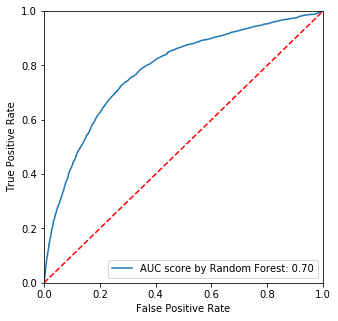

In [24]:
plot_roc('Random Forest',ytest, rf_predict,rf_predict_prob)

In [25]:
ultimate_df.columns

Index(['avg_dist', 'avg_surge', 'city', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'status'],
      dtype='object')

In [26]:
rf.feature_importances_

array([0.16556383, 0.00664809, 0.1954374 , 0.11785738, 0.09285207,
       0.42164122])

SVC

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [28]:
# Scale the data
scale = StandardScaler()
scale.fit(xtrain)
xtrain_transform = scale.transform(xtrain)
xtest_transform = scale.transform(xtest)

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
svc = SVC()
svc.fit(xtrain_transform, ytrain)

svc_predict = svc.predict(xtest_transform)

In [30]:
model_test('SVC', ytest, svc_predict)

The accuracy of SVC model is: 0.73
The confusion matrix is:
[[8013 1278]
 [2757 2952]]
The auc score is: 0.69
The F1-score is: 0.59


KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)
knn_predict = knn.predict(xtest)
knn_predict_prob = knn.predict_proba(xtest)[:,1]

In [33]:
model_test('knn', ytest, knn_predict)

The accuracy of knn model is: 0.71
The confusion matrix is:
[[7494 1797]
 [2535 3174]]
The auc score is: 0.68
The F1-score is: 0.59


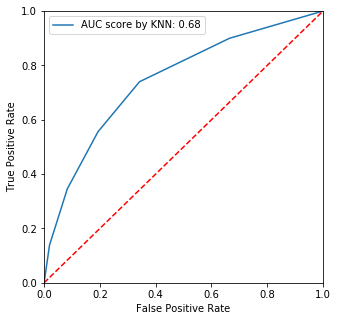

In [34]:
plot_roc('KNN', ytest, knn_predict, knn_predict_prob)

Gradient Boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

In [36]:
gb = GradientBoostingClassifier()
gb.fit(xtrain, ytrain)
gb_predict = gb.predict(xtest)
gb_predict_prob = gb.predict_proba(xtest)[:,1]

In [37]:
model_test('Gradient Boosting', ytest, gb_predict)

The accuracy of Gradient Boosting model is: 0.75
The confusion matrix is:
[[7774 1517]
 [2266 3443]]
The auc score is: 0.72
The F1-score is: 0.65


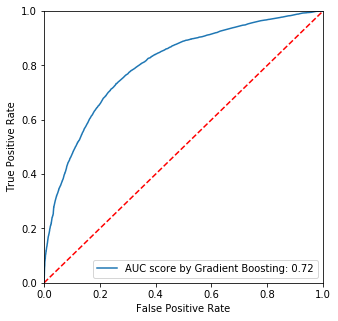

In [38]:
plot_roc('Gradient Boosting', ytest, gb_predict, gb_predict_prob)

In [39]:
# Reduce the threshold to be 0.4, which increase the true positive rate
model_test('Threshould tuned gradient boosting',ytest, (gb_predict_prob>0.4).astype(int))

The accuracy of Threshould tuned gradient boosting model is: 0.74
The confusion matrix is:
[[7040 2251]
 [1631 4078]]
The auc score is: 0.74
The F1-score is: 0.68


Text(0,0.5,'True Positive Rate')

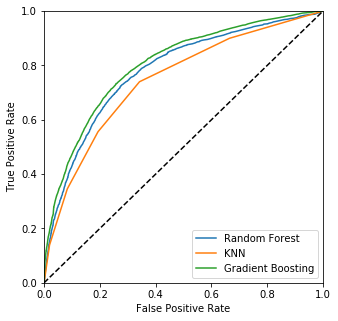

In [40]:
# Comparison of ROC curve for four types of models, it is indicated gradient boosting and neuron network provide the highest AUC score
plt.figure(figsize=(5,5))
for i,j in zip([rf_predict_prob, knn_predict_prob, gb_predict_prob], 
               ['Random Forest', 'KNN', 'Gradient Boosting']):
    fpr, tpr, _ = roc_curve(ytest, i)
    plt.plot(fpr, tpr, label = j)
plt.legend(loc = 'best')
plt.plot([0,1],[0,1], 'k--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Per the above graph, we find that gradient boosting  performs best in terms of prediction accuracy (74%), roc-auc score (74%), and f1-score (68%). For this project, the ultimate company will care more on the accuracy of prediction given the user is active. More specifically, Ultimate Company cares about more about how we performed in predicting out the true negative rate so that they can target these users.

Ultimate Company can use these results to predict out users who are most likely to stop using the services and see how they can improve the experience (examples being lower surge fares during surge times or discounted ultimate black services) to improve retention.